# Описание проекта

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Задача: модель должна предсказать коэффициент восстановления золота из золотосодержащей руды на основе данных с параметрами добычи и очистки. 

Цель: создать модель, которая поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

# 1. Подготовка данных

In [1]:
#!pip install -U scikit-learn --user

In [2]:
# подгрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
import matplotlib.ticker as ticker
sns.set()

%matplotlib inline

## 1.1 Открыть файлы и изучить их

Данные находятся в трёх файлах:
 - gold_recovery_train.csv — обучающая выборка;
 - gold_recovery_test.csv — тестовая выборка;
 - gold_recovery_full.csv — исходные данные.

In [3]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

Посмотрим на общую информацию каждой выборки:

In [4]:
def print_info(df, name):
    print('-' * 15, name, '-' * 15, '\n')
    print(df.info())
    print('-' * 48)

for i in ((train, 'Тренеровочная выборка'), (test, 'Тестовая выборка'), (full, 'Исходная выборка')):
    print_info(*i)

--------------- Тренеровочная выборка --------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-nu

__Разберемся с наименованиями и со значениями в столбцах:__
- rougher.input.feed - исходное сырье на входе (более интересен черновой концентрат золота)
- rougher.input.floatbank - исходные флоатильные реагенты на входе
- rougher.output.concentrate - коцентрат на выходе с содержанием соответствующего элемента или солей
- rougher.output.tail - отвальные хвосты исходного сырья после флотации
- rougher.output.recovery - всего сырья на выходе (эффективность обогащения)
- rougher.state.floatbank - исходное состояние флотационной установки

__Для следующих этапов этапов очистки (primary_cleaner - первичная очистка, secondary_cleaner - вторичная очистка) приведены параметры:__
- input - реагент на входе и общий объем реагента (для primary_cleaner)
- output - концентрат после первичной очистки (для primary_cleaner)
- state.floatbank - состояние флотационной установки
- output.tail - отвальные хвосты после флотации

__На выходе получаем финальный концентрат:__
- final.output.concentrate - финальный концентрат элементов
- final.output.tail - отвальные хвосты в конце всего процесса очистки
- final.output.recovery - всего концентата на выходе

Процесс флотации приведен на следующем рисунке:

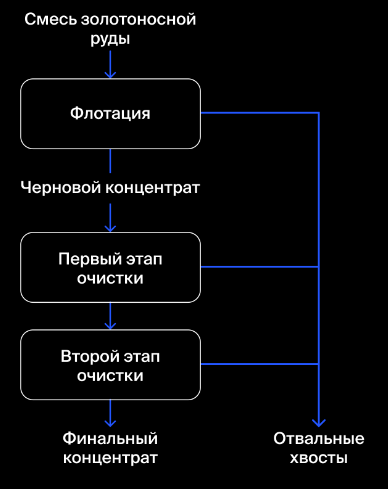

### Вывод:

1. Данные имеют пропуски практически в каждом столбце.
2. Даты можно привести к типу datetime.

## 1.2 Проверить, что эффективность обогащения рассчитана правильно

In [5]:
# напишем функцию для расчета эффективности обогащения
def eff(C, F, T):
    """
    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.
    """    
    return (C * (F - T)) * 100 / (F * (C - T))

Возьмем фрагмент обучающего датасета для проведения расчетов:

In [6]:
# для проверки правильности расчета можно не учитывать отсутствующие значения в признаках
eff_calc = train[['rougher.output.concentrate_au', 
                  'rougher.input.feed_au', 
                  'rougher.output.tail_au', 
                  'rougher.output.recovery']].dropna()

Запишем в отдельный признак значения, рассчитаные с помощью функции расчета эффективности:

In [7]:
eff_calc['calc'] = eff(eff_calc['rougher.output.concentrate_au'], 
                       eff_calc['rougher.input.feed_au'], 
                       eff_calc['rougher.output.tail_au'])

Рассчитаем среднюю абсолютную ошибку между имеющимися в тренеровочном наборе значениями и рассчитанными по формуле:

In [8]:
MAE = (1 / eff_calc.shape[0]) * ((eff_calc['calc'] - eff_calc['rougher.output.recovery']).abs().sum())
MAE

1.0898633667227425e-14

### Вывод:

Значение MAE крайне мало, можно сделать вывод, что значения, записаные в признак rougher.output.recovery, посчитаны верно.

### 1.3  Анализ признаков, недоступных в тестовой выборке

In [9]:
# отсутствующие признаки запишем в список
list_dif = []
for i in train.columns:
    if i not in list(test.columns):
        list_dif.append(i)

In [10]:
# посмотрим на типы данных в этих столбцах
train[list_dif].dtypes

final.output.concentrate_ag                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.concentrate_au                           float64
final.output.recovery                                 float64
final.output.tail_ag                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
final.output.tail_au                                  float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_cleaner.output.concentrate_sol                float64
primary_cleaner.output.concentrate_au                 float64
primary_cleaner.output.tail_ag                        float64
primary_cleaner.output.tail_pb                        float64
primary_cleaner.output.tail_sol                       float64
primary_

В тестовой выборке отсутствуют следующие данные:
1. Параметры продукта (output) на всех стадиях.
2. Расчетные данные (calculation).

### Вывод

Данные, отсутствующие в тестовой выборке, имеют тип float. Отсутствие данных можно объяснить тем, что некоторые параметры замеряются и/или рассчитываются значительно позже.

### 1.3 Предобработка данных

Переведем дату во всех датафреймах к типу datetime

In [11]:
for i in train, test, full:
    i['date'] = pd.to_datetime(i['date'])
    # отсортируем по дате
    i.sort_values(by='date', inplace=True)
    # проверка
    print(i['date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


Соседние значения в датафреймах не сильно отличаются друг от друга, поэтому можно заменить пропуски с помощью KNNImputer. 



In [12]:
# создадим объект заполнителя nan с помощью KNN
imp = KNNImputer(n_neighbors=3)

# создадим функцию, которая будет убирать пропуски и возвращать очищенный датафрейм
def fill_na_knn(data):
    # сохраним дату в отдельный DataFame
    date = pd.DataFrame(data['date'], index=data.index)
    column_data = data.columns[1:]
    data_transform = imp.fit_transform(data[column_data])
    data_df = pd.DataFrame(data_transform, columns=column_data, index=data.index)
    
    return pd.merge(date, data_df, left_index=True, right_index=True)

Перед заполнением пропусков удалим объекты с пропусками в целевых признаках rougher.output.recovery и final.output.recovery

In [13]:
for i in (train, full):
    size = i.shape[0]
    i.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)
    print(f'Удалено объектов - {size - i.shape[0]}')

Удалено объектов - 2711
Удалено объектов - 3277


Преобразуем все три датасета:

In [14]:
%%time
# обучающая выборка
df_train = fill_na_knn(train)

# тестовая выборка
df_test = fill_na_knn(test)

# весь набор данных
df_full = fill_na_knn(full)

CPU times: user 40.4 s, sys: 3.54 s, total: 43.9 s
Wall time: 44.7 s


Посмотрим на общую информацию по каждому датасету:

In [15]:
for i in ((df_train, 'Тренеровочная выборка'), (df_test, 'Тестовая выборка'), (df_full, 'Исходная выборка')):
    print_info(*i)

--------------- Тренеровочная выборка --------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  14149 non-null datetime64[ns]
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         1414

### Выводы:

1. Для заполнения пропусков был использован метод ближайших соседей, пропуски были устранены во всех датасетах.
2. Даты приведены к типу datetime.

# 2. Анализ данных

### 2.1 Исследование изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки

Для того, чтобы оценить, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки, посчитаем процентное соотношение концентраций на каждом этапе по отношению к предыдущему. Для начала выделим в отдельные датафреймы столбцы с концентратами на каждом этапе для каждого элемента:

In [16]:
# концентраты золота
au_conc = df_full[[x for x in df_full.columns if ('.concentrate_au' in x) | ('input.feed_au' in x)]]

# концентраты свинца
pb_conc = df_full[[x for x in df_full.columns if ('.concentrate_pb' in x) | ('input.feed_pb' in x)]]

# концентраты серебра
ag_conc = df_full[[x for x in df_full.columns if ('.concentrate_ag' in x) | ('input.feed_ag' in x)]]

Напишем функцию, которая из этого датафрейма напечатает средние соотношения содержания для каждого этапа:

In [17]:
def concentrate(data, text):
    rougher_mean = data['rougher.output.concentrate_' + text].mean()
    print('Средняя концентрация {} до очистки в среднем равна {}'.format(text, rougher_mean))
    
    primary_cleaner_mean = data['primary_cleaner.output.concentrate_' + text].mean()
    if ((primary_cleaner_mean / rougher_mean) - 1) < 0:
        print('Средняя концентрация {} после первичной очистки равна {}, что на {:.1%} меньше, чем до очистки'.format(text, 
                                                                                                          primary_cleaner_mean, 
                                                                                                          1 - (primary_cleaner_mean / rougher_mean)))
    else:
        print('Средняя концентрация {} после первичной очистки равна {}, что на {:.1%} больше, чем до очистки'.format(text, 
                                                                                                          primary_cleaner_mean, 
                                                                                                          (primary_cleaner_mean / rougher_mean) - 1))
    
    final_mean = data['final.output.concentrate_' + text].mean()
    if ((final_mean / primary_cleaner_mean) - 1) < 0:
        print('Средняя концентрация {} на финальной стадии обработки равна {}, что на {:.1%} меньше, \nчем после первичной очистки'.format(text, 
                                                                                                                             final_mean, 
                                                                                                                             1 - (final_mean / primary_cleaner_mean)))
    else:
        print('Средняя концентрация {} на финальной стадии обработки равна {}, что на {:.1%} больше, \nчем после первичной очистки'.format(text, 
                                                                                                                             final_mean, 
                                                                                                                             (final_mean / primary_cleaner_mean) - 1))
    
    # построим графики распределения плотностей концентраций металлов на каждой стадии
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.distplot(data['rougher.input.feed_' + text], kde_kws={"shade": True}, hist=False, ax=ax, label='Перед флотацией')
    sns.distplot(data['rougher.output.concentrate_' + text], kde_kws={"shade": True}, hist=False, ax=ax, label='После флотации')
    sns.distplot(data['primary_cleaner.output.concentrate_' + text], kde_kws={"shade": True}, hist=False, ax=ax, label='После первичной очистки')
    sns.distplot(data['final.output.concentrate_' + text], kde_kws={"shade": True}, hist=False, ax=ax, label='На выходе')
    ax.set_ylabel('Частота')
    ax.set_xlabel('Значение')
    ax.set_title('Концентрация ' + text + ' на разных стадиях', size=16, pad=10)
    ax.legend(loc='upper right');

Посмотрим на изменение концентрации серебра:

Средняя концентрация ag до очистки в среднем равна 11.994759359873429
Средняя концентрация ag после первичной очистки равна 8.44240807771906, что на 29.6% меньше, чем до очистки
Средняя концентрация ag на финальной стадии обработки равна 5.168448159628606, что на 38.8% меньше, 
чем после первичной очистки


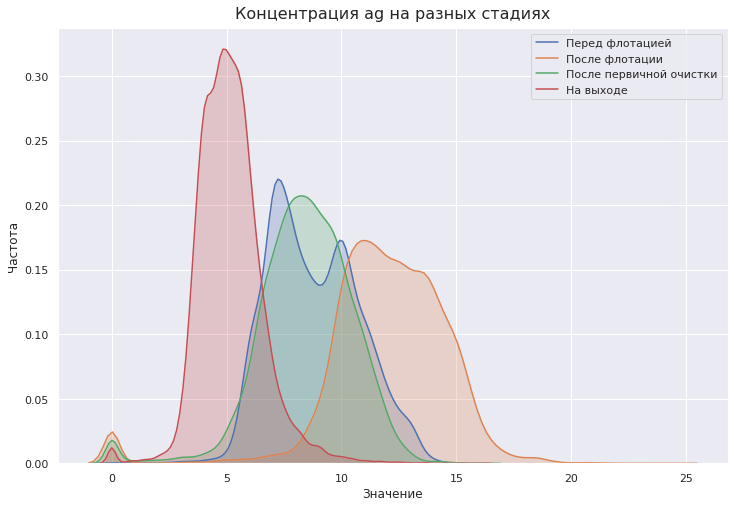

In [18]:
concentrate(ag_conc, 'ag')

Изменение концентрации свинца:

Средняя концентрация pb до очистки в среднем равна 7.606272313195004
Средняя концентрация pb после первичной очистки равна 9.821632815406598, что на 29.1% больше, чем до очистки
Средняя концентрация pb на финальной стадии обработки равна 9.978899836492216, что на 1.6% больше, 
чем после первичной очистки


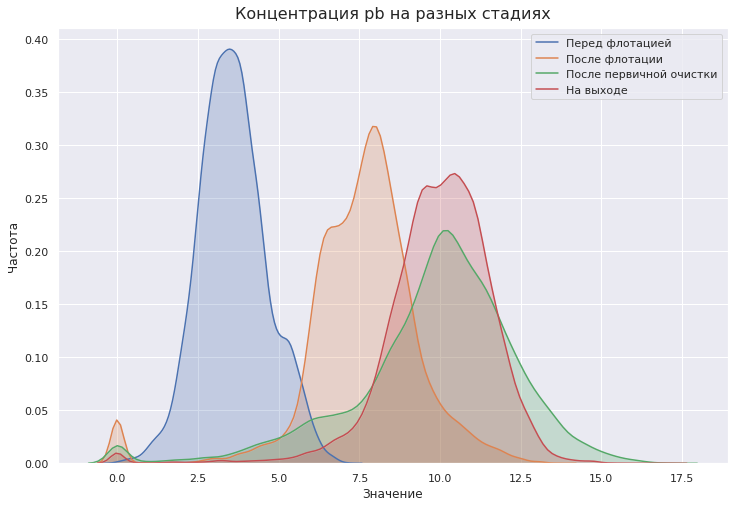

In [19]:
concentrate(pb_conc, 'pb')

Изменение концентрации золота:

Средняя концентрация au до очистки в среднем равна 19.772000139486313
Средняя концентрация au после первичной очистки равна 32.1194004078765, что на 62.4% больше, чем до очистки
Средняя концентрация au на финальной стадии обработки равна 44.0765129419528, что на 37.2% больше, 
чем после первичной очистки


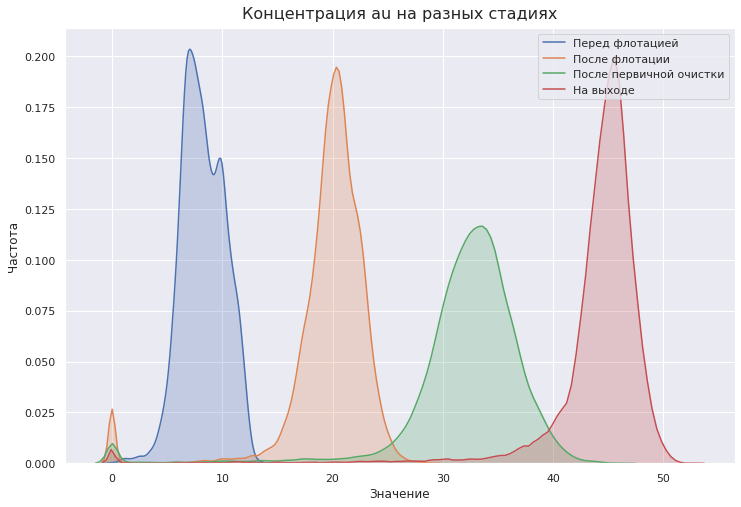

In [20]:
concentrate(au_conc, 'au')

### Выход:


1. На разных этапах технологического процесса мы имеем изменения в концентрации металлов, а именно увеличения концентрации золота и свинца, а также уменьшения концентрации серебра.
2. Проанализировав графики распределения плотностей концентраций металлов можно сделать вывод, что в области значения = 0 имеются выбросы для всех металлов из-за чего распределение будет неравномерным и окажет влияние на построение модели в будущем. Скорее всего, от этих выбрасов придется избавиться.

### 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Для сравнения распределений построим гистограммы и боксплоты, для обучающей и тестовой выборки:

In [21]:
# определим функцию, с помощью которой нарисуем необходимые графики
def hist_and_box(data, text, text_label='Размер гранул сырья'):
    fig, ax = plt.subplots(2, 1, figsize=(14, 12), constrained_layout=True)
    fig.suptitle(text, fontsize=16, va = 'bottom')
    ax[0].hist(data['rougher.input.feed_size'], color='y', bins=50)
    ax[1] = sns.boxplot(data['rougher.input.feed_size'])
    ax[1].set_xlabel(text_label, labelpad=15)
    ax[0].set_ylabel('Количество', labelpad=15)    

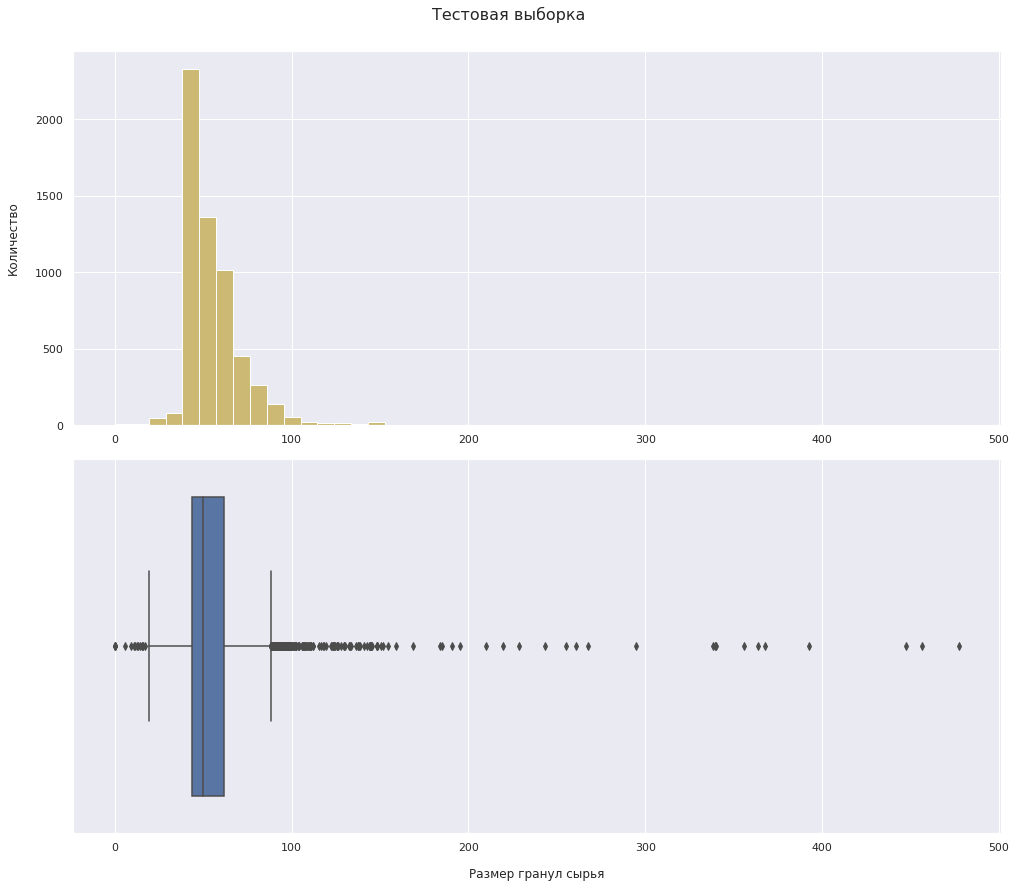

In [22]:
hist_and_box(df_test, 'Тестовая выборка')

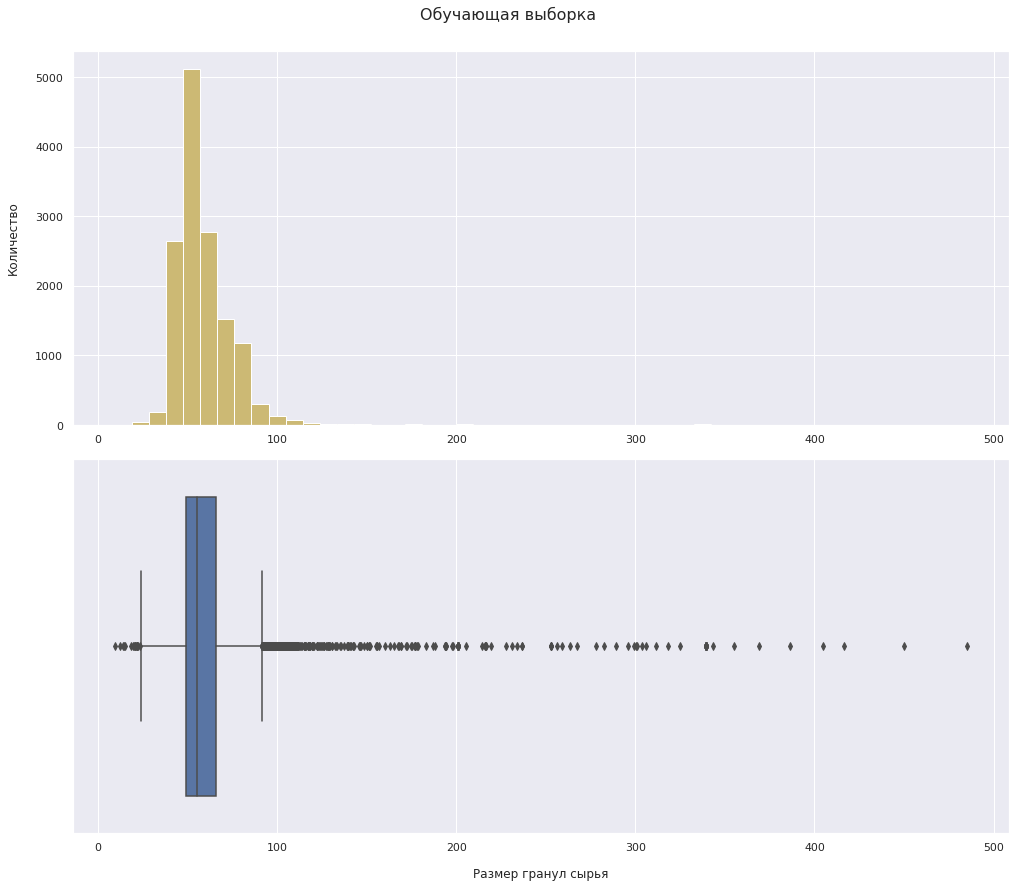

In [23]:
hist_and_box(df_train, 'Обучающая выборка')

### Вывод:


1. Распределения в тестовом и обучающем наборе имеют выбросы после размеров более 90 и менее 35.
2. В тестовой выборке большенство значений лежит в диапазоне от 40 до 60, а в тренеровочной - 50 от 70.

#### Удалим выбросы и еще раз посмотрим на распределения:

In [24]:
# напишем функцию удаления аномалий для переменного количества выборок
def remove_anom(*data, minimum=35, maximum=90, col_name='rougher.input.feed_size'):
    result = []
    for i in data:
        data_size = i.shape[0]
        print('Удаляем аномальные значения в {}'.format(col_name))
        print('Количество объектов до удаления выбросов = {}'.format(data_size))
        i = i[(i[col_name] < maximum) & (i[col_name] > minimum)]
        print('Количество объектов после удаления выбросов = {}, удалено {} объектов'.format(i.shape[0], data_size - i.shape[0]))
        print()
        result.append(i)
    return tuple(result)

In [25]:
# удалим аномальные данные для тестового, обучающего и полного набора
df_train_cl, df_test_cl, df_full_cl = remove_anom(df_train, df_test, df_full)

Удаляем аномальные значения в rougher.input.feed_size
Количество объектов до удаления выбросов = 14149
Количество объектов после удаления выбросов = 13537, удалено 612 объектов

Удаляем аномальные значения в rougher.input.feed_size
Количество объектов до удаления выбросов = 5856
Количество объектов после удаления выбросов = 5533, удалено 323 объектов

Удаляем аномальные значения в rougher.input.feed_size
Количество объектов до удаления выбросов = 19439
Количество объектов после удаления выбросов = 18621, удалено 818 объектов



Посмотрим на выборки

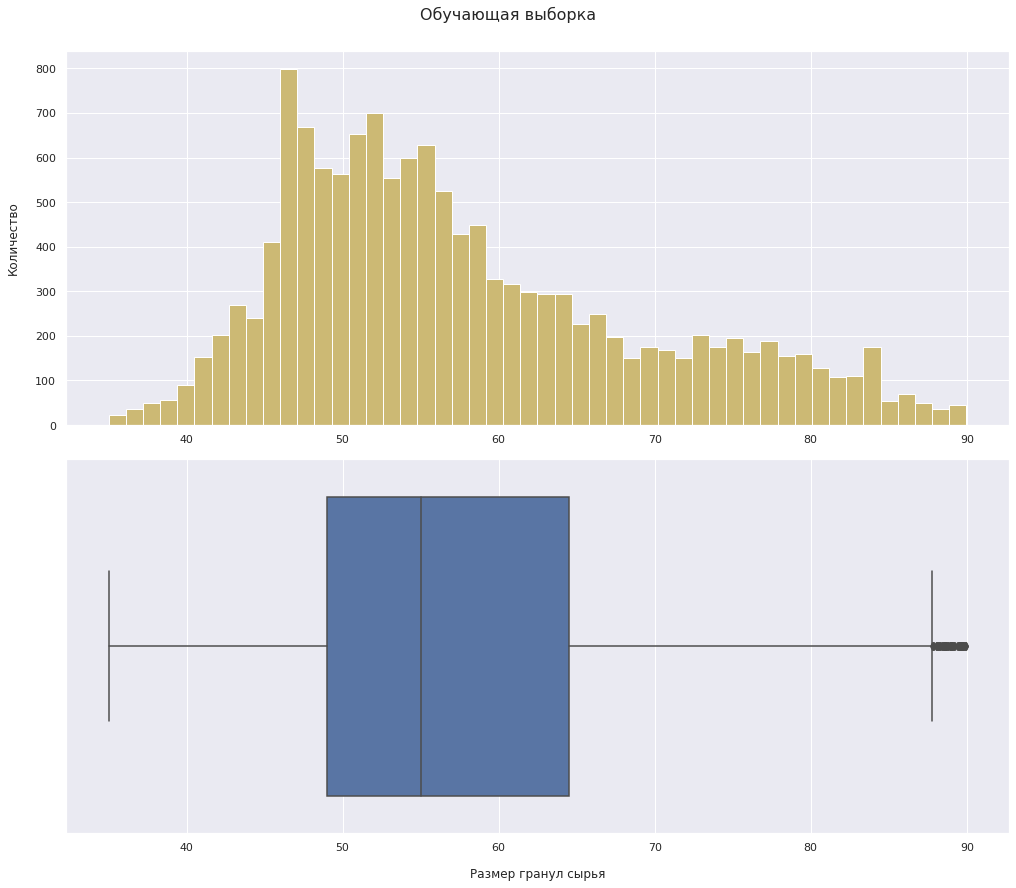

In [26]:
hist_and_box(df_train_cl, 'Обучающая выборка')

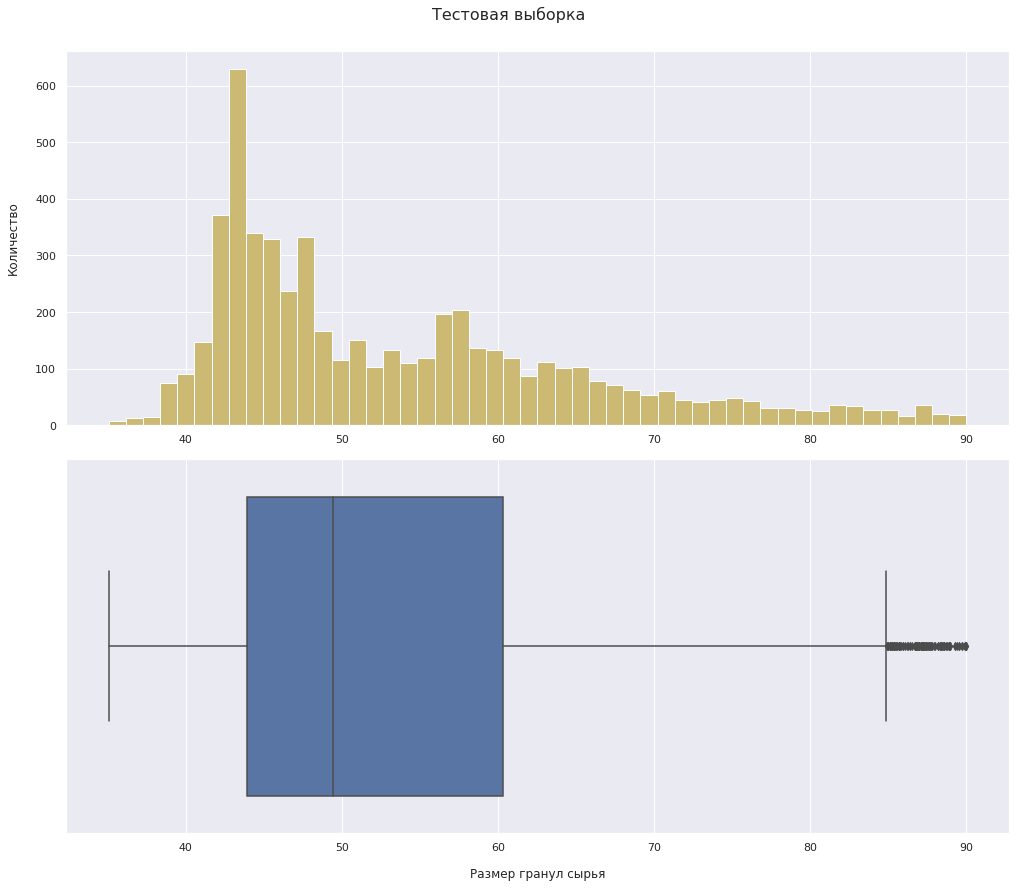

In [27]:
hist_and_box(df_test_cl, 'Тестовая выборка')

Так распределения стали меньше отличаться, следовательно и оценка модели, которую буду делать позже, будет лучше.

### 2.3 Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Сведения о концентрации веществ присутствуют только в обучающей и в полной выборке

Создадим список с названиями признаков, относящимся к концентратам:

In [28]:
# концентраты 
conc = [x for x in df_train_cl.columns if ('.concentrate' in x)] + ['rougher.input.feed_ag', 
                                                                    'rougher.input.feed_pb',
                                                                    'rougher.input.feed_sol',
                                                                    'rougher.input.feed_au']
conc

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_au']

Для исследования добавим столбцы final_sum, prim_sum, rougher_sum, в которые запишем суммы для каждого элемента.

In [29]:
for i in (df_train_cl, df_full_cl):
    i['final_sum'] = i[conc[0:4]].sum(axis=1)
    i['prim_sum'] = i[conc[4:8]].sum(axis=1)
    i['rougher_out_sum'] = i[conc[8:12]].sum(axis=1)
    i['rougher_in_sum'] = i[conc[12:]].sum(axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Построим распределения в этих столбцах с помощью функции, принимающей в качестве аргументов датафрейм и заголовок к графику

In [30]:
def plt_box(data, title):
    plt.figure(figsize=(15, 10))
    ax = sns.boxplot(data=data[['final_sum', 'prim_sum', 'rougher_out_sum', 'rougher_in_sum']], orient="h", palette="Set2")
    plt.title('Суммарные показатели концентрации всех элементов на каждой стадии ({})'.format(title))
    # добавим больше линий сетке по оси x
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5));

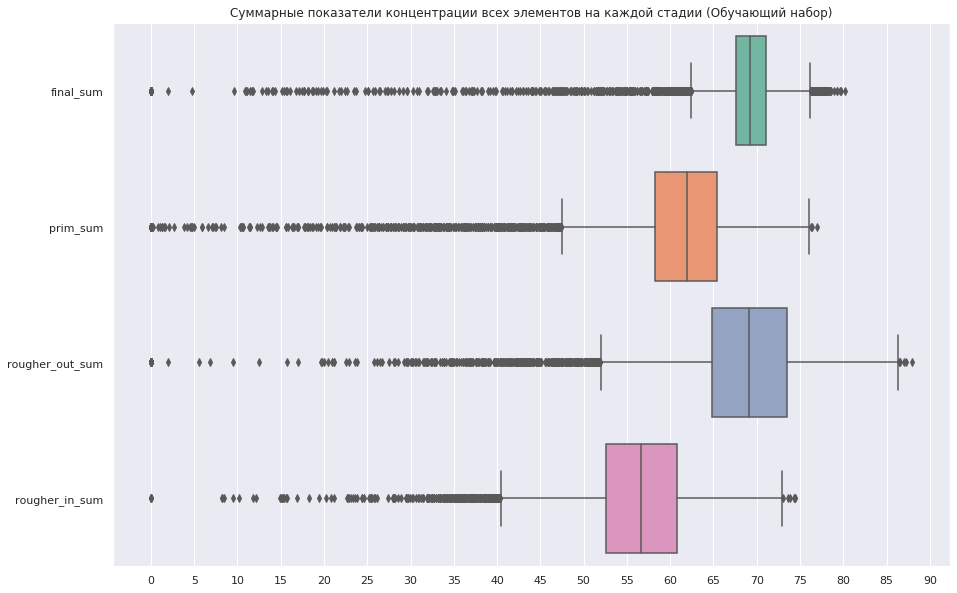

In [31]:
plt_box(df_train_cl, title='Обучающий набор')

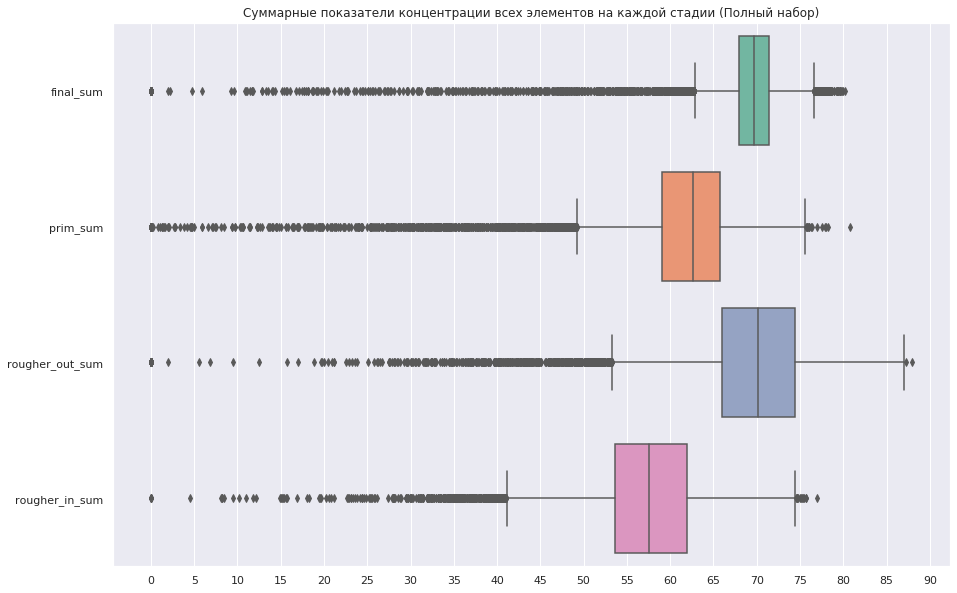

In [32]:
plt_box(df_full_cl, title='Полный набор')

Определим границы выбросов. Выбросы в обучающей и полной выборке присутствуют примерно с одних и тех же значений. Отбросим 2,5% выбросов внизу диапазона и 0,5% вверху:

In [33]:
anom = df_full_cl[['final_sum', 'prim_sum', 'rougher_out_sum', 'rougher_in_sum']].quantile([0.025, 0.995])
anom

,final_sum,prim_sum,rougher_out_sum,rougher_in_sum
0.025,55.676722,33.151070,34.809246,42.182878
0.995,77.299695,73.736752,83.847611,72.454166


In [34]:
# подготовим словари для передачи в функцию, с помощью которой удалим аномалии
del_fin_sum, del_prim_sum, del_rou_out, del_rou_in = {}, {}, {}, {}

# заполним словари значениями
for i in ((del_fin_sum, 'final_sum'), 
          (del_prim_sum, 'prim_sum'), 
          (del_rou_out, 'rougher_out_sum'), 
          (del_rou_in, 'rougher_in_sum')):
    i[0]['minimum'] = anom[i[1]][0.025]
    i[0]['maximum'] = anom[i[1]][0.995]
    i[0]['col_name'] = i[1]

Так как аномальные значения примерно повторяются для полной и обучающей выборки - удалим их из обеих выборок.

Произведем необходимые преобразования с помощью ранее определенной функции remove_anom

In [35]:
# уберем аномальные значения во всех трех столбцах
df_train_cl_a, df_full_cl_a = remove_anom(*remove_anom(*remove_anom(*remove_anom(df_train_cl, df_full_cl, 
                    **del_fin_sum), 
                **del_prim_sum),
            **del_rou_out),
        **del_rou_in
)

Удаляем аномальные значения в final_sum
Количество объектов до удаления выбросов = 13537
Количество объектов после удаления выбросов = 13183, удалено 354 объектов

Удаляем аномальные значения в final_sum
Количество объектов до удаления выбросов = 18621
Количество объектов после удаления выбросов = 18061, удалено 560 объектов

Удаляем аномальные значения в prim_sum
Количество объектов до удаления выбросов = 13183
Количество объектов после удаления выбросов = 12784, удалено 399 объектов

Удаляем аномальные значения в prim_sum
Количество объектов до удаления выбросов = 18061
Количество объектов после удаления выбросов = 17571, удалено 490 объектов

Удаляем аномальные значения в rougher_out_sum
Количество объектов до удаления выбросов = 12784
Количество объектов после удаления выбросов = 12436, удалено 348 объектов

Удаляем аномальные значения в rougher_out_sum
Количество объектов до удаления выбросов = 17571
Количество объектов после удаления выбросов = 17119, удалено 452 объектов

Удаляе

Построим боксплоты

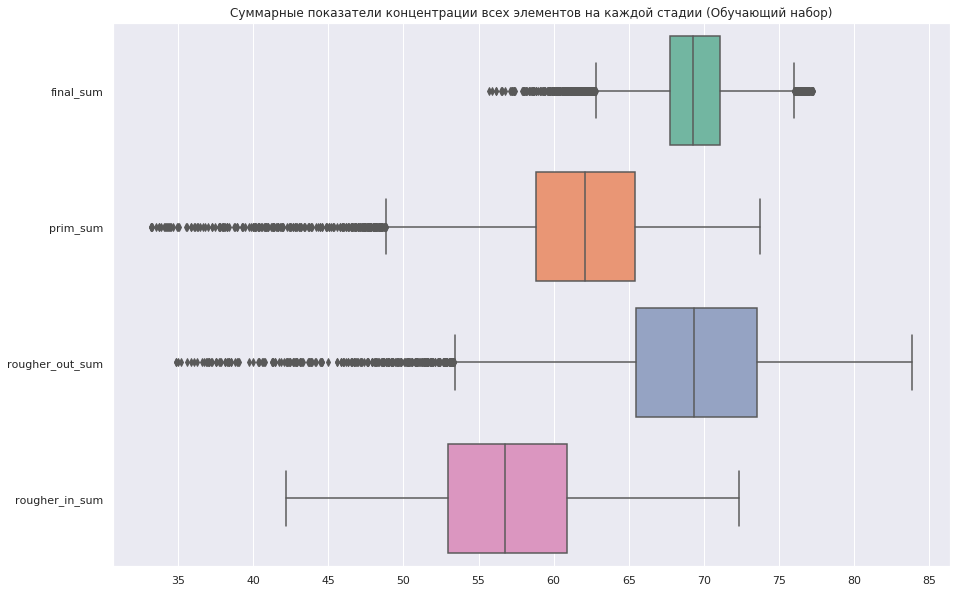

In [36]:
plt_box(df_train_cl_a, title='Обучающий набор')

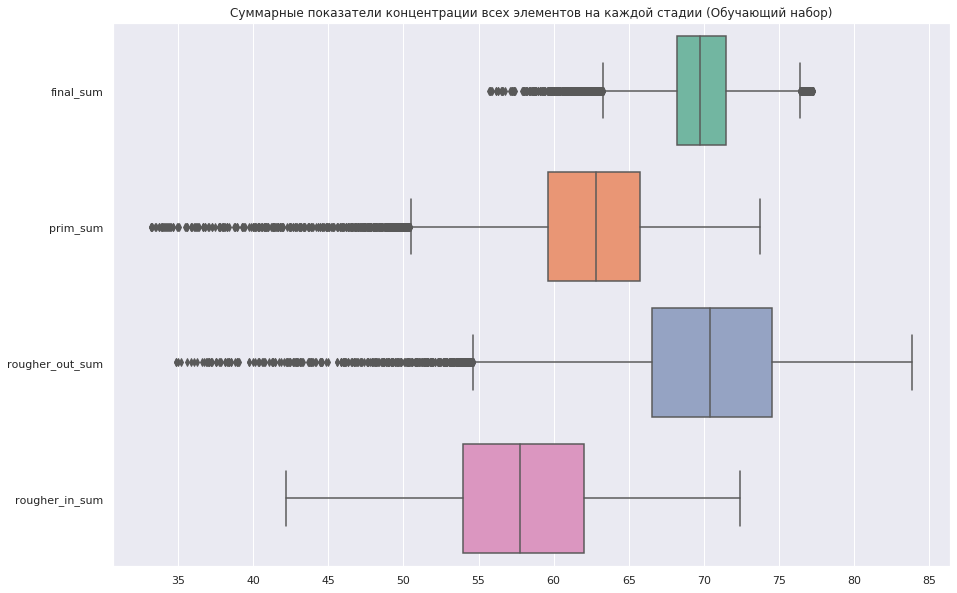

In [37]:
plt_box(df_full_cl_a, title='Обучающий набор')

### Вывод

После проведения анализа боксплотов обучающего и полного набора потребовалось удалить аномальные значения в выборках, так как эти значения могут внести ошибку в предсказания будущих моделей.

# 3. Модель

## 3.1 Подготовка данных

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Напишем функцию для ее вычисления:

In [38]:
def sMAPE(target, predict, name=None):
    predict = pd.DataFrame(predict)[0]
    smape = (1 / len(target)) * ((target - predict).abs() / ((target.abs() + predict.abs()) / 2)).sum() * 100
    if name:
        print(f'sMAPE для {name} равно {smape}')
    return smape

Итоговая метрика складывается из двух величин - sMAPE для чернового концентрата и sMAPE для финального концентрата:

In [39]:
def final_sMAPE(smape_rougher, smape_fin_rec):
    res_sMAPE = 0.25 * smape_rougher + 0.75 * smape_fin_rec
    print(f'Финальное sMAPE равно {res_sMAPE}')

<font color='green'>Функции корректные, все в порядке. </font>


Добавим столбцы со значениями целевых признаков из общего набора в тестовый и обработаем пропуски. Напишем для этого функцию:

In [40]:
def transform_test(df_test, df_full, *columns):
    # сначала для обоих датасетов сделаем индексами даты:
    
    test = df_test.set_index('date')
    full = df_full.set_index('date')
    
    # добавим целевые признаки в тест
    for i in columns:
        test[i] = full.loc[test.index][i]
    test.dropna(subset=list(columns), inplace=True)
    # функция вернет тестовый набор данных с целевыми признаками, которые не равны nan
    return test.reset_index(drop=True)

In [41]:
df_test_cl_a = transform_test(df_test_cl, df_full_cl_a, 'rougher.output.recovery', 'final.output.recovery')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


### Анализ распределений целевых признаков

Для корректности прогноза будущих моделей распределения целевых признаков на обучающей и тестовой выборке должны быть примерно одинаковы. Посмотрим на эти распределения.

__Черновой концентрат__

In [42]:
# функция будет рисовать гистограммы
def hist_plot(train, test, col_name):
    plt.figure(figsize=(15, 10))
    plt.hist(train[col_name], bins=50)
    plt.hist(test[col_name], bins=50);

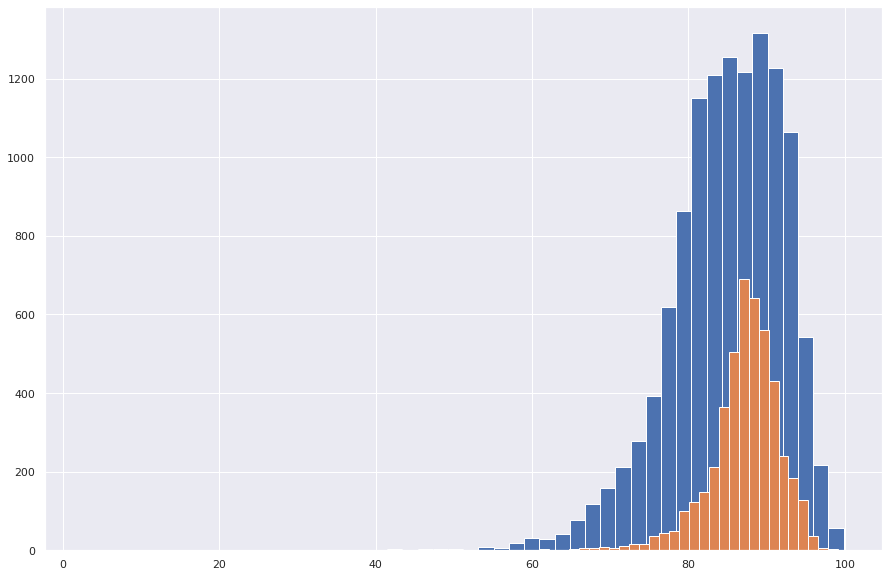

In [43]:
hist_plot(df_train_cl_a, df_test_cl_a, 'rougher.output.recovery')

Распределения отличаются, есть выбросы. Модель логистической регресси к таким данным точно не подойдет. Избавимся от выбросов - удалим все объекты со значением целевого признака для чернового концентрата менее 60.

In [44]:
for i in (df_train_cl_a, df_test_cl_a):
    size = i.shape[0]
    ind = i[i['rougher.output.recovery'] < 60].index
    i.drop(ind, inplace=True)
    print(f'Удалено объектов - {size - i.shape[0]}')

Удалено объектов - 74
Удалено объектов - 3


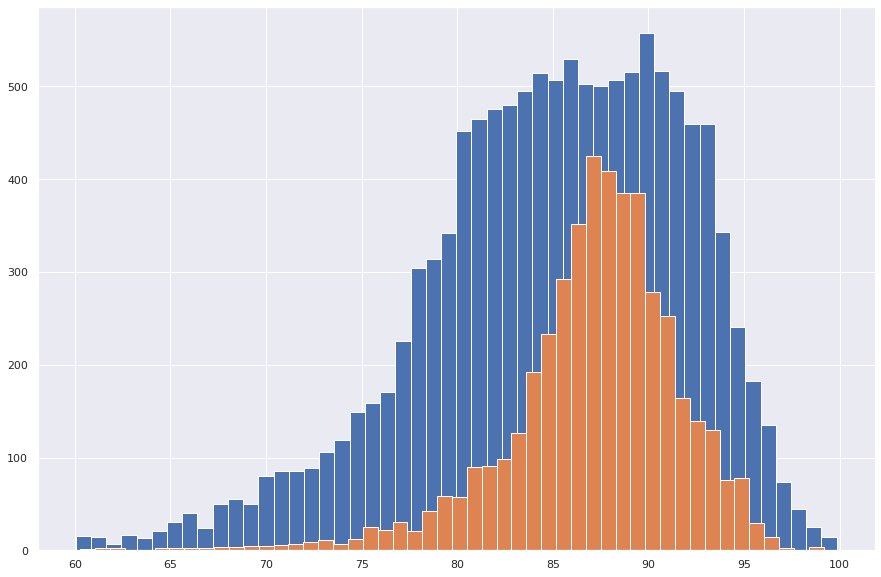

In [45]:
# посмотрим на результат
hist_plot(df_train_cl_a, df_test_cl_a, 'rougher.output.recovery')

__Финальный концентрат__

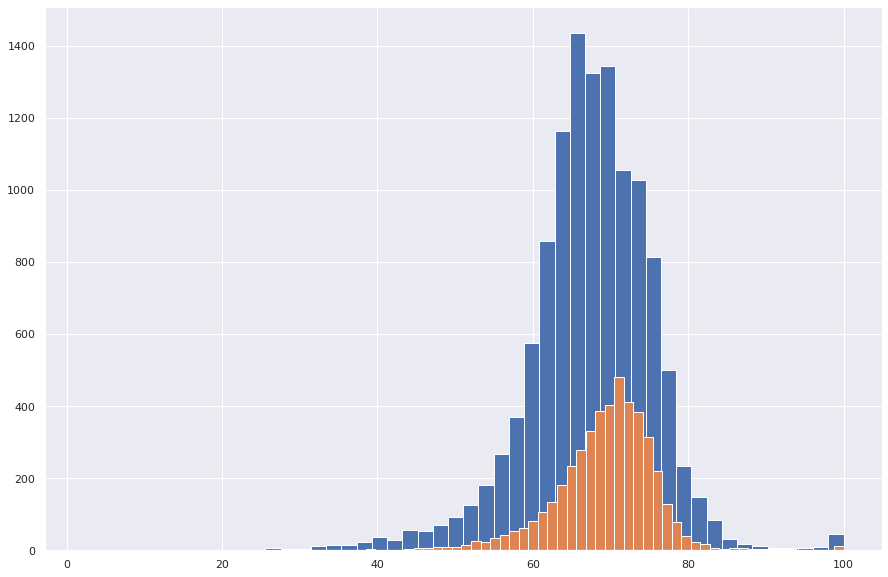

In [46]:
hist_plot(df_train_cl_a, df_test_cl_a, 'final.output.recovery')

Как видно из распределений, лучше избавиться от значений больше 85 и меньше 45. Так и поступим

In [47]:
for i in (df_train_cl_a, df_test_cl_a):
    size = i.shape[0]
    ind = i[(i['final.output.recovery'] < 45)|(i['final.output.recovery'] > 85)].index
    i.drop(ind, inplace=True)
    print(f'Удалено объектов - {size - i.shape[0]}')

Удалено объектов - 317
Удалено объектов - 58


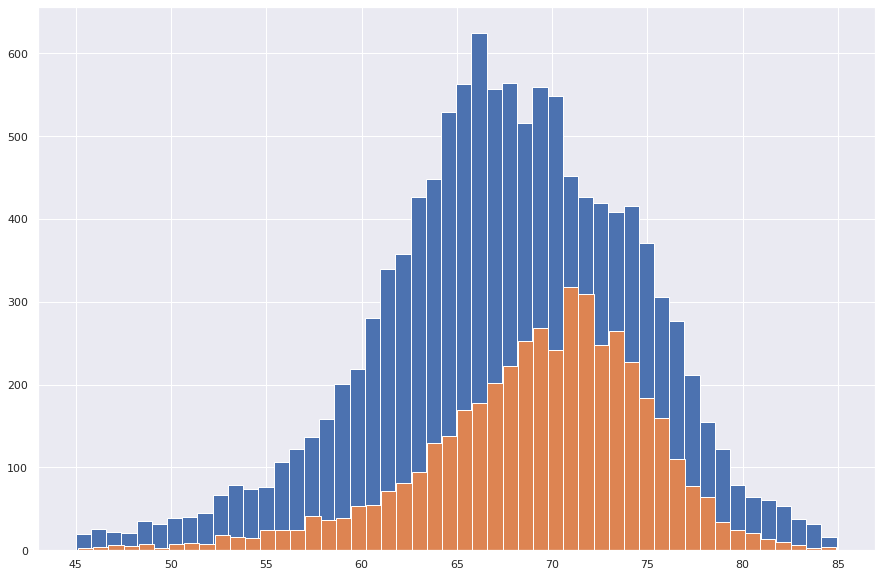

In [48]:
# проверка
hist_plot(df_train_cl_a, df_test_cl_a, 'final.output.recovery')

Теперь, возможно, будущие модели будут лучше обучены.

Подготовим признаки для обучения моделей. Выделим целевые признаки:

Так как в тестовой выборке признаков меньше, чем в обучающей, удалим из обучающей ненужные для уравнивания их размеров, при этом сохраним rougher.output.recovery и final.output.recovery в отдельные объекты целевого признака. Напишем функцию, которая будет принимать исходные обучающую и тестовую выборки, а возвращать 2 целевых признака и отмасштабированные train и test

In [49]:
def get_train_test(df_train, df_test, df_full, target_1='rougher.output.recovery', target_2='final.output.recovery'):
    # уберем признак с датой, эта информация не пригодится для модели
    df_train = df_train.drop(['date'], axis=1)
    # выделяем целевые признаки
    targ_train_1 = df_train[target_1]
    targ_train_2 = df_train[target_2]
    
    targ_test_1 = df_test[target_1]
    targ_test_2 = df_test[target_2]
    # запишем названия всех признаков за исключением целевых в одельный список
    columns_train = [name for name in df_test.columns if 'output' not in name]
    # масштабируем данные и получаем конечные датафреймы с признаками
    scaler = StandardScaler()
    
    # настраиваем scaler по обучающей выборке
    scaler.fit(df_train[columns_train])
    train, test = scaler.transform(df_train[columns_train]), scaler.transform(df_test[columns_train]) 
    
    # возвращаем готовые признаки
    return train, test, targ_train_1, targ_train_2, targ_test_1, targ_test_2

Посмотрим на распределеления целевых признаков:

In [50]:
X_train, X_test, y_rougher_train, y_final_train, y_rougher_test, y_final_test = get_train_test(df_train_cl_a, df_test_cl_a, df_full_cl_a)

Размерности одинаковы. Данные готовы для обучения моделей!

## 3.2 Выбор модели

Так как требуется предсказать количественный признак, будем решать задачу регрессии. Выбор произведем из четырех моделей - LinearRegression, DecisionTreeRegressor, RandomForestRegressor и модели, предсказывающей всегда только среднее из обучающей выборки.

Для выбора модели используем кроссвалидацию на 3 блоках (для ускорения расчетов), в качестве метрики - sMAPE.

In [51]:
def cross_val_mod(model, target_1, target_2, name_model):
    result = []
    for i in ((target_1, 'чернового концентрата'), (target_2, 'финального концентрата')):
        print(f'Результаты кросс-валидации({name_model}) для {i[1]}:')
        predict_mod = cross_val_predict(model, X_train, i[0], cv=3)  
        result.append(sMAPE(i[0], predict_mod, i[1]))
        print('-' * 20)
    final_sMAPE(result[0], result[1])
    print('-' * 20)
    print()

<font color='green'>Функция для проведения кросс-валидации верная, молодец. </font>


Создадим объекты моделей:

In [52]:
# линейная регрессия
lin_reg = LinearRegression()

# дерево решений
tree = DecisionTreeRegressor(random_state=42)

# случайный лес
rf = RandomForestRegressor(random_state=42)

Посмотрим на качество моделей без настройки их гиперпараметров.

In [53]:
%%time
for i in ((lin_reg, 'Линейная регрессия'), (tree, 'Дерево решений'), (rf, 'Случайный лес')):
    cross_val_mod(i[0], y_rougher_train, y_final_train, i[1])

Результаты кросс-валидации(Линейная регрессия) для чернового концентрата:
sMAPE для чернового концентрата равно 5.54493877856401
--------------------
Результаты кросс-валидации(Линейная регрессия) для финального концентрата:
sMAPE для финального концентрата равно 6.324809832908865
--------------------
Финальное sMAPE равно 6.129842069322651
--------------------

Результаты кросс-валидации(Дерево решений) для чернового концентрата:
sMAPE для чернового концентрата равно 5.628511663020203
--------------------
Результаты кросс-валидации(Дерево решений) для финального концентрата:
sMAPE для финального концентрата равно 8.013455459056207
--------------------
Финальное sMAPE равно 7.417219510047206
--------------------

Результаты кросс-валидации(Случайный лес) для чернового концентрата:
sMAPE для чернового концентрата равно 4.840357006631897
--------------------
Результаты кросс-валидации(Случайный лес) для финального концентрата:
sMAPE для финального концентрата равно 5.618821287694249
----

Из полученных данных видно, что без настройки гиперпараметров лучшая модель - модель случайного леса. Попробуем поиграть параметрами случайного леса и дерева решений.

## 3.2 Подбор гиперпараметров для дерева решений и модели случайного леса

Создадим словари со значениями подбираемых параметров:

In [95]:
param_forest = {
    'max_depth': range(3, 10),
    'n_estimators': range(5, 21, 5),
    'max_features': range(3, 8),
}

param_tree = {
    'max_depth': range(3, 15), 
    'max_features': range(5, 10),
    'min_samples_leaf': range(1, 9),
}

Произведем поиск оптимальных параметров для каждой модели и проанализируем их. Параметр кроссвалидации выберем равным 3 для ускорения расчетов. Метрика - sMAPE

Запишем метрику в отдельную переменную. Чем значение меньше, тем лучше:

In [96]:
smape_metrica = make_scorer(sMAPE, greater_is_better=False)

In [97]:
grid_forest = GridSearchCV(rf, param_forest, cv=3, scoring=smape_metrica)
grid_tree = GridSearchCV(tree, param_tree, cv=3, scoring=smape_metrica)

__Поиск оптимальных параметров для прогнозирования rougher__

Определим функцию для проведения кроссвалидации и вывода значения sMAPE для концентрата:

In [98]:
def cross_val_conc(model, name_model, target, text):
    print(f'Результат кросс-валидации({name_model}) для {text}:')
    predict_mod = cross_val_predict(model, X_train, target, cv=3)  
    result = sMAPE(target, predict_mod, text)
    print('-' * 20)
    return result

In [99]:
%%time
for i in grid_forest, grid_tree:
    i.fit(X_train, y_rougher_train)

CPU times: user 3min 3s, sys: 324 ms, total: 3min 4s
Wall time: 3min 5s


Посмотрим на лучшие параметры:

In [100]:
grid_tree.best_params_

{'max_depth': 8, 'max_features': 8, 'min_samples_leaf': 6}

In [101]:
grid_forest.best_params_

{'max_depth': 8, 'max_features': 7, 'n_estimators': 5}

Выберем модели с лучшими параметрами и посмотрим на метрики:

In [102]:
%%time
for i in ((grid_tree.best_estimator_, 'Дерево решений (лучшая модель)'),
          (grid_forest.best_estimator_, 'Случайный лес (лучшая модель)')):
    cross_val_conc(i[0], i[1], y_rougher_train, 'чернового концентрата')

Результат кросс-валидации(Дерево решений (лучшая модель)) для чернового концентрата:
sMAPE для чернового концентрата равно 5.00122048402304
--------------------
Результат кросс-валидации(Случайный лес (лучшая модель)) для чернового концентрата:
sMAPE для чернового концентрата равно 4.474753206059992
--------------------
CPU times: user 1 s, sys: 4 ms, total: 1 s
Wall time: 1 s


Модель дерева решений стала получше, но случайный лес всё равно дает лучший результат. Возьмем модель случайного леса с подобранными параметрами для предсказания rougher:

In [103]:
best_model_rought = grid_forest.best_estimator_

__Поиск оптимальных параметров для прогнозирования final__

In [104]:
param_forest_fin = {
    'max_depth': range(3, 8),
    'n_estimators': range(30, 61, 5),
    'max_features': range(3, 8),
}

param_tree_fin = {
    'max_depth': range(3, 15), 
    'max_features': range(5, 15),
    'min_samples_leaf': range(1, 9),
}

In [105]:
grid_forest_fin = GridSearchCV(rf, param_forest_fin, cv=3, scoring=smape_metrica)
grid_tree_fin = GridSearchCV(tree, param_tree_fin, cv=3, scoring=smape_metrica)

In [106]:
%%time
for i in grid_forest_fin, grid_tree_fin:
    i.fit(X_train, y_final_train)

CPU times: user 11min 29s, sys: 740 ms, total: 11min 29s
Wall time: 11min 35s


In [107]:
grid_forest_fin.best_params_

{'max_depth': 4, 'max_features': 4, 'n_estimators': 35}

In [108]:
grid_tree_fin.best_params_

{'max_depth': 6, 'max_features': 9, 'min_samples_leaf': 3}

In [109]:
%%time
for i in ((grid_tree_fin.best_estimator_, 'Дерево решений (лучшая модель)'),
          (grid_forest_fin.best_estimator_, 'Случайный лес (лучшая модель)')):
    cross_val_conc(i[0], i[1], y_rougher_train, 'финального концентрата')

Результат кросс-валидации(Дерево решений (лучшая модель)) для финального концентрата:
sMAPE для финального концентрата равно 5.367194783432134
--------------------
Результат кросс-валидации(Случайный лес (лучшая модель)) для финального концентрата:
sMAPE для финального концентрата равно 4.31824679571348
--------------------
CPU times: user 1.34 s, sys: 16 ms, total: 1.36 s
Wall time: 1.37 s


И опять модель случайного леса лучше дерева решений. Выберем для прогнозирования финального концентрата лучшие параметры:

In [110]:
best_model_final = grid_forest_fin.best_estimator_

Обучим модель на обучающем наборе:

In [111]:
%%time
best_model_rought.fit(X_train, y_rougher_train)
best_model_final.fit(X_train, y_final_train)

CPU times: user 796 ms, sys: 0 ns, total: 796 ms
Wall time: 808 ms


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=35, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

## 3.3 Проверка модели на тестовой выборке

Проверим нашу обученную модель на тестовой выборке и посчитаем наши метрики:

In [112]:
# предсказания для чернового конценрата
predict_roug = best_model_rought.predict(X_test)

# предсказание для финального концентрата
predict_fin = best_model_final.predict(X_test)

Посчитаем sMAPE для каждого предсказания:

In [113]:
sm_roug = sMAPE(y_rougher_test, predict_roug, 'чернового концентрата')
sm_fin = sMAPE(y_final_test, predict_fin, 'финального концентрата')

sMAPE для чернового концентрата равно 4.707508732627727
sMAPE для финального концентрата равно 6.561402940543433


Посчитаем финальную метрику:

In [114]:
final_sMAPE(sm_roug, sm_fin)

Финальное sMAPE равно 6.0979293885645065


__Проверим модель на адекватность__, сравнив ее с моделью, предсказывающей только средние значения:

In [115]:
# модель, предсказывающая среднее
mean_model_rougher = DummyRegressor(strategy='mean')
mean_model_final = DummyRegressor(strategy='mean')

# обучим модели
mean_model_rougher.fit(X_train, y_rougher_train)
mean_model_final.fit(X_train, y_final_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

Сохраним предсказания в отдельных переменных и посчитаем sMAPE

In [116]:
pred_mean_roug = mean_model_rougher.predict(X_test)
pred_mean_fin = mean_model_final.predict(X_test)

In [117]:
mean_sm_roug = sMAPE(y_rougher_test, pred_mean_roug, 'чернового концентрата')
mean_sm_fin = sMAPE(y_final_test, pred_mean_fin, 'финального концентрата')

sMAPE для чернового концентрата равно 4.4764750431338065
sMAPE для финального концентрата равно 7.083615957579599


In [118]:
final_sMAPE(mean_sm_roug, mean_sm_fin)

Финальное sMAPE равно 6.4318307289681504


Как видно из расчетов - финальный sMAPE моделей на основе случайного леса имеет значение, меньшее на 7,5%, что является существенным для выполнения предсказаний.

### Вывод:

Путем подбора гиперпараметров модели случайного леса удалось получить лучшее значение финального sMAPE = 4,47 на обучающих данных для чернового концентрата и 4,32 для финального.

Были обучены 2 модели с разными гиперпараметрами для различных предсказаний.

Финальный sMAPE моделей на основе случайного леса на тестовых данных составил 6,1, в свою очередь финальный sMAPE на модели, предсказывающей только среднее значение составил 6,43, что на 5% хуже выбранных моделей.


# Итоговый комментарий

~~Спасибо, задание выполнено очень качественно, но его надо немного доработать. Ждем исправленную версию проекта, пиши, если возникнут вопросы.~~

Работа отличная, так держать :)

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке выполнения
- [ ]  Выполнен шаг 1: данные подготовлены
    - [ ]  Проверена формула вычисления эффективности обогащения
    - [ ]  Проанализированы признаки, недоступные в тестовой выборке
    - [ ]  Проведена предобработка данных
- [ ]  Выполнен шаг 2: данные проанализированы
    - [ ]  Исследовано изменение концентрации элементов на каждом этапе
    - [ ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ ]  Исследованы суммарные концентрации
    - [ ]  Проанализированы и обработаны аномальные значения
- [ ]  Выполнен шаг 3: построена модель прогнозирования
    - [ ]  Написана функция для вычисления итогового *sMAPE*
    - [ ]  Обучено и проверено несколько моделей
    - [ ]  Выбрана лучшая модель, её качество проверено на тестовой выборке